# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyjags
import seaborn as sns
from sklearn import preprocessing
import time
import typing as tp
import xarray as xr
xr.set_options(display_style="html");

# Read Dataset

In [4]:
data_filename = os.path.join('data', 'urine.csv')
df = pd.read_csv(data_filename, index_col=0)
df.dropna(inplace=True)
df.head()

,r,gravity,ph,osmo,cond,urea,calc
2,0,1.017,5.74,577.0,20.0,296,4.49
3,0,1.008,7.20,321.0,14.9,101,2.36
4,0,1.011,5.51,408.0,12.6,224,2.15
5,0,1.005,6.52,187.0,7.5,91,1.16
6,0,1.020,5.27,668.0,25.3,252,3.34


In [5]:
df.shape

(77, 7)

# Exploratory Data Analysis

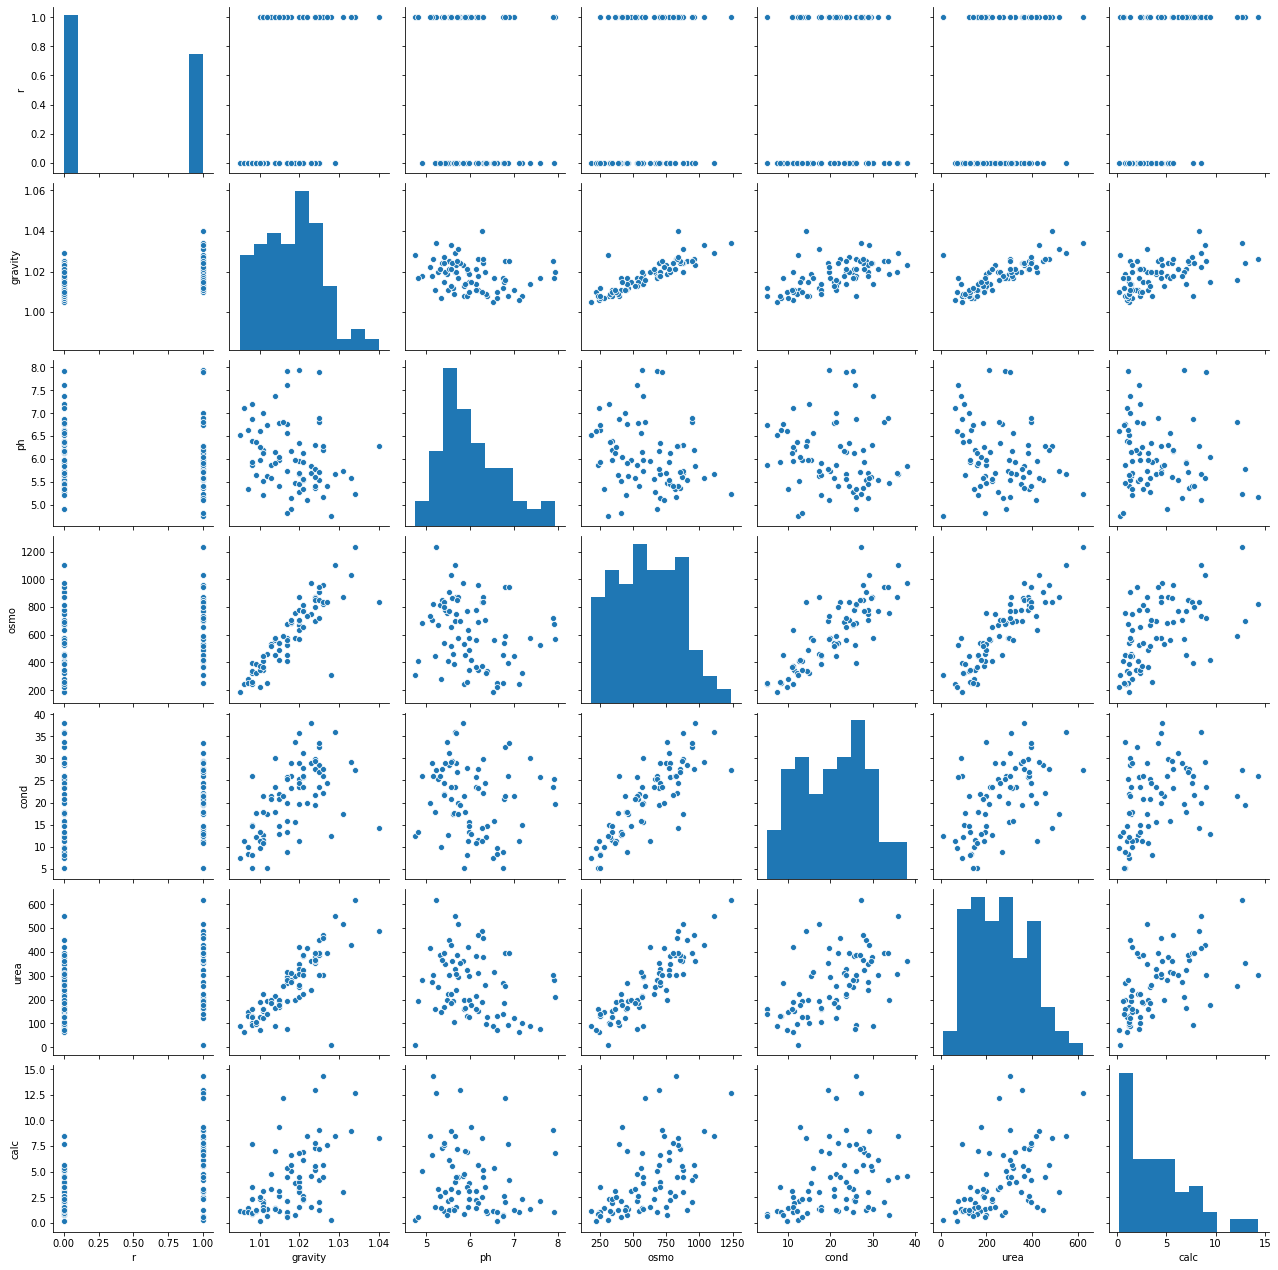

In [6]:
sns.pairplot(df);

Note that a number of explanatory variables are colinear. We have to perform variable selection.

# Standardize the explanatory variables and put a prior close to zero on the variables

In [7]:
for column_name in ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']:
    df[column_name] = preprocessing.scale(df[column_name])

After standardization, the mean of each explanatory variable is 0 and the standard deviation is 1

In [8]:
df.describe()

,r,gravity,ph,osmo,cond,urea,calc
count,77.000000,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01
mean,0.428571,-4.374567e-15,2.541009e-15,1.600451e-16,-1.643707e-16,8.074349e-17,-8.651089e-18
std,0.498117,1.006557e+00,1.006557e+00,1.006557e+00,1.006557e+00,1.006557e+00,1.006557e+00
min,0.000000,-1.793005e+00,-1.785215e+00,-1.793131e+00,-1.987576e+00,-1.947006e+00,-1.218280e+00
25%,0.000000,-8.294659e-01,-7.118412e-01,-8.558165e-01,-8.306334e-01,-7.976363e-01,-8.274916e-01
50%,0.000000,-3.575284e-03,-1.403044e-01,-8.242651e-02,6.222402e-02,-5.710282e-02,-3.054225e-01
75%,1.000000,8.223153e-01,5.009320e-01,7.960436e-01,7.664496e-01,7.682834e-01,6.196473e-01
max,1.000000,3.024690e+00,2.647680e+00,2.616032e+00,2.149750e+00,2.758467e+00,3.107871e+00


# Model 1: Include all Explanatory Variables

## Construct Model

Use a double exponential prior with high probability close to zero

In [9]:
jags_model_string_1 = ''' 
model {
  for (i in 1:length(r)) {
    r[i] ~ dbern(p[i])
    logit(p[i]) = int 
                + b[1]*gravity[i] 
                + b[2]*ph[i] 
                + b[3]*osmo[i] 
                + b[4]*cond[i] 
                + b[5]*urea[i] 
                + b[6]*calc[i]
  }
  
  int ~ dnorm(0.0, 1.0/25.0)
  for (j in 1:6) {
    b[j] ~ ddexp(0.0, sqrt(2.0))
  }
}
'''

Construct data dictionary

In [10]:
jags_data_1 = {column_name: df[column_name].values for column_name in df.columns}
parameters = ['int', 'b']

Construct JAGS model

In [11]:
jags_model_1 \
    = pyjags.Model(code=jags_model_string_1, 
                   data=jags_data_1, 
                   chains=3)

adapting: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00


## Fit Model

Draw burn-in sample of 1000 iterations

In [12]:
jags_model_1.sample(1000, vars=[])

sampling: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00


{}

Draw actual sample of 5000 iterations

In [13]:
jags_samples_from_model_1 = jags_model_1.sample(5000, vars=parameters)

sampling: iterations 15000 of 15000, elapsed 0:00:03, remaining 0:00:00


Convert dictionary of samples to Arviz object

In [14]:
idata_jags_model_1 = \
    pyjags.convert_pyjags_samples_dict_to_arviz_inference_data(jags_samples_from_model_1)

## Compute Diagnostics

Compute Gelman-Rubin statistic

In [15]:
az.rhat(idata_jags_model_1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.002
    b_2      float64 1.0
    b_3      float64 1.003
    b_4      float64 1.003
    b_5      float64 1.006
    b_6      float64 1.0
    int      float64 1.0

The Gelman-Rubin statistic is close to 1 for all parameters

Generate autocorrelation plot

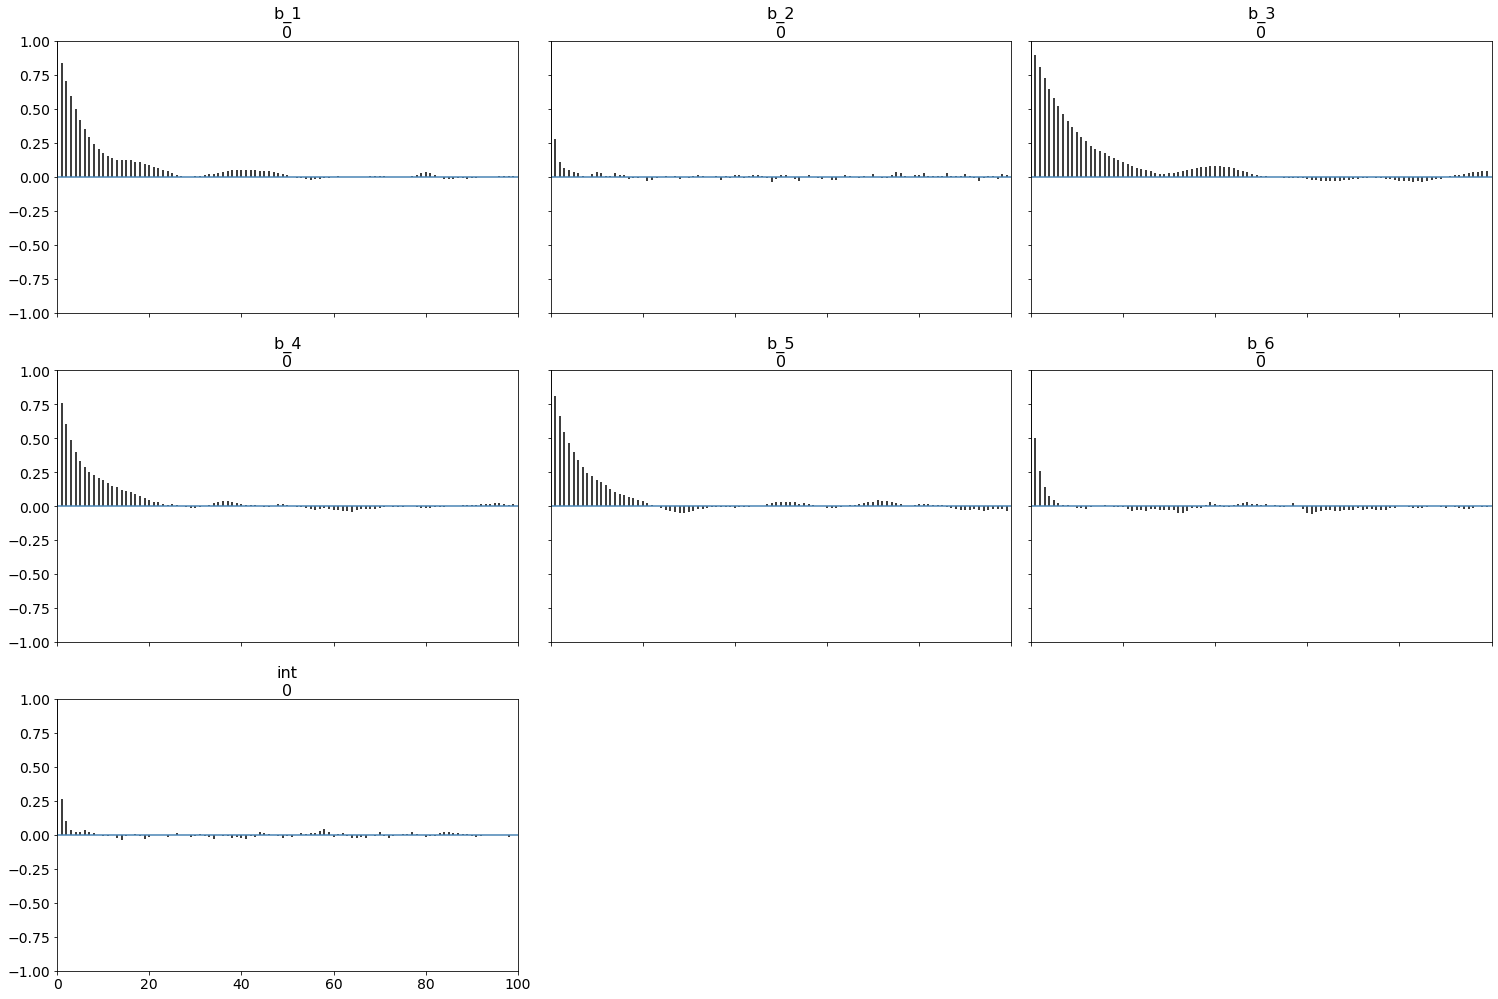

In [16]:
az.plot_autocorr(idata_jags_model_1);

Compute effective sample size

In [17]:
az.ess(idata_jags_model_1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.241e+03
    b_2      float64 7.556e+03
    b_3      float64 770.3
    b_4      float64 1.265e+03
    b_5      float64 1.168e+03
    b_6      float64 5.051e+03
    int      float64 7.319e+03

Calculate DIC

In [18]:
dic_1 = pyjags.dic_samples(jags_model_1, n_iter=1000)
dic_1

updating: iterations 3000 of 3000, elapsed 0:00:01, remaining 0:00:00


Mean deviance: 68.54
penalty: 5.62
Penalized deviance: 74.15

## Generate Trace Plot

/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages

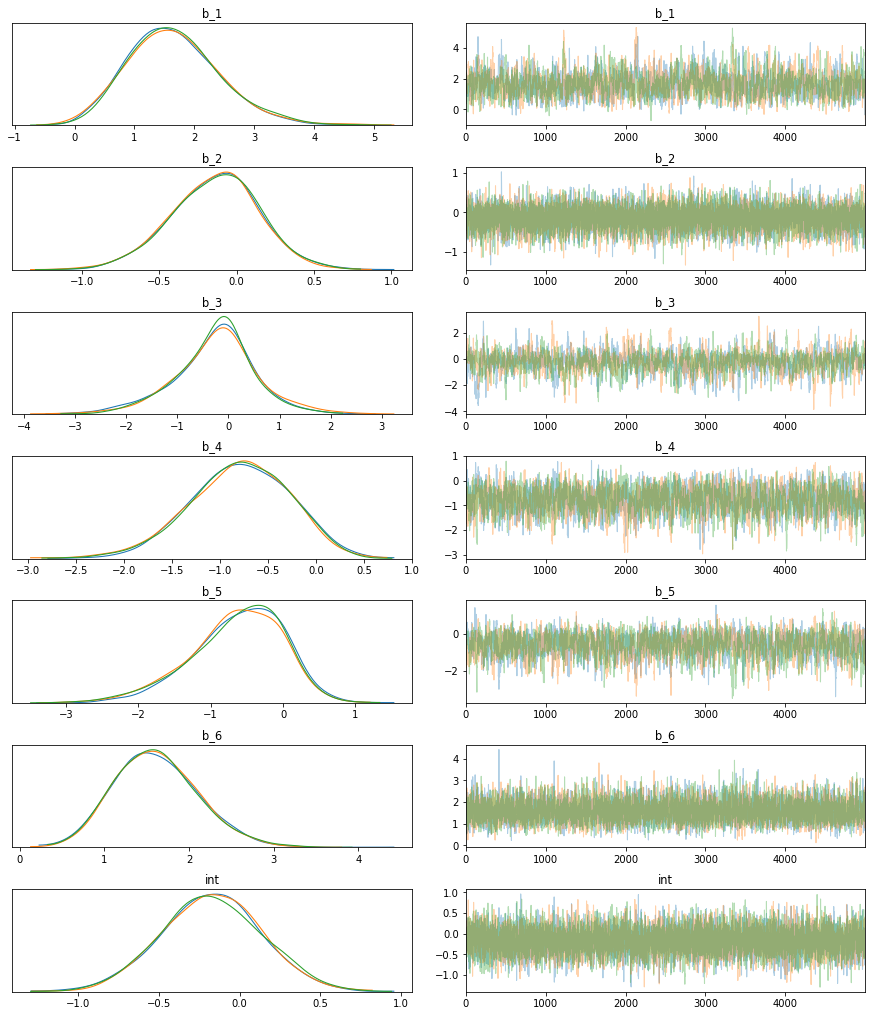

In [19]:
az.plot_trace(idata_jags_model_1);

We see that ph and osmosis are insignificant. Furthermore, urea is not significant either and is strongly correlated with gravity (see pairs plot). Hence, we will remove these three variables in a new model.

# Model 2: Use Gravity, Conductivity, and Calcium Concentration as Explanatory Variables

## Construct Model

In [20]:
jags_model_string_2 = ''' 
model {
  for (i in 1:length(r)) {
    r[i] ~ dbern(p[i])
    logit(p[i]) = int 
                + b[1]*gravity[i] 
                + b[2]*cond[i] 
                + b[3]*calc[i]
  }

  int ~ dnorm(0.0, 1.0/25.0)
  for (j in 1:3) {
    b[j] ~ dnorm(0.0, 1.0/25)
  }
}
'''

Construct data dictionary

In [21]:
jags_data_2 = {column_name: df[column_name].values for column_name in ('gravity', 'cond', 'calc', 'r')}
parameters = ['int', 'b']

Construct JAGS model

In [22]:
jags_model_2 \
    = pyjags.Model(code=jags_model_string_2, 
                   data=jags_data_2, 
                   chains=3)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


## Fit Model

Draw burn-in sample of 1000 iterations

In [23]:
jags_model_2.sample(1000, vars=[])

sampling: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


{}

Draw actual sample of 5000 iterations

In [24]:
jags_samples_from_model_2 = jags_model_2.sample(5000, vars=parameters)

sampling: iterations 15000 of 15000, elapsed 0:00:02, remaining 0:00:00


Convert dictionary of samples to Arviz object

In [25]:
idata_jags_model_2 = \
    pyjags.convert_pyjags_samples_dict_to_arviz_inference_data(jags_samples_from_model_2)

## Compute Diagnostics

Compute Gelman-Rubin statistic

In [26]:
az.rhat(idata_jags_model_2)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.001
    b_2      float64 1.001
    b_3      float64 1.001
    int      float64 1.001

The Gelman-Rubin statistic is close to 1 for all parameters

Generate autocorrelation plot

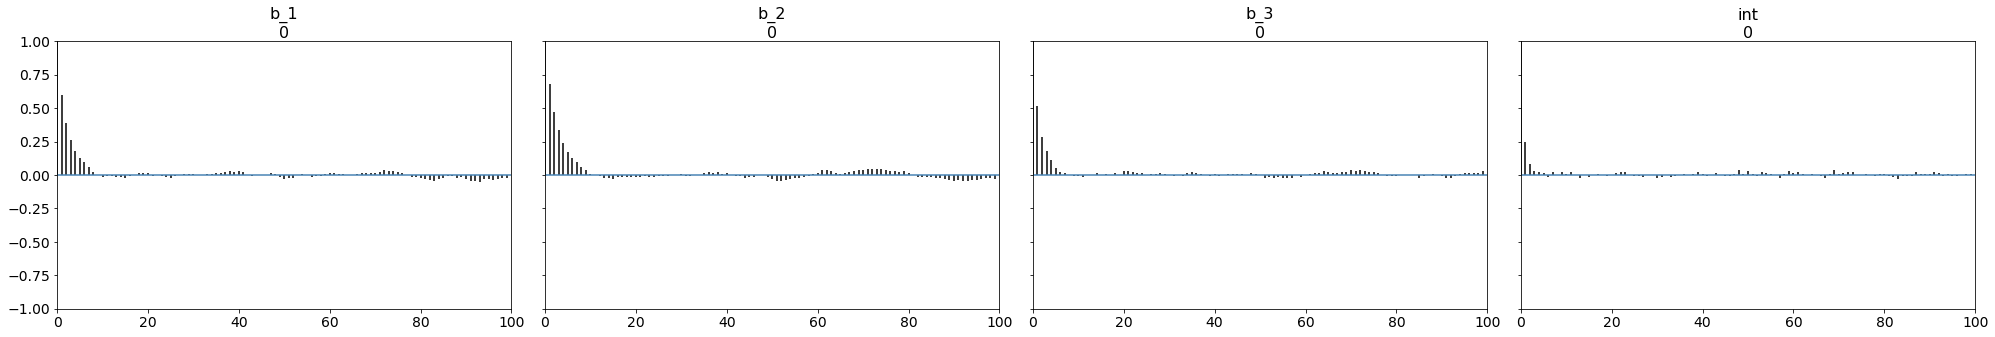

In [27]:
az.plot_autocorr(idata_jags_model_2);

Compute effective sample size

In [28]:
az.ess(idata_jags_model_2)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 3.484e+03
    b_2      float64 2.917e+03
    b_3      float64 4.771e+03
    int      float64 7.821e+03

Calculate DIC

In [29]:
dic_2 = pyjags.dic_samples(jags_model_2, n_iter=1000)
dic_2

updating: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


Mean deviance: 71.29
penalty: 4.08
Penalized deviance: 75.36

## Generate Traceplot

/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages

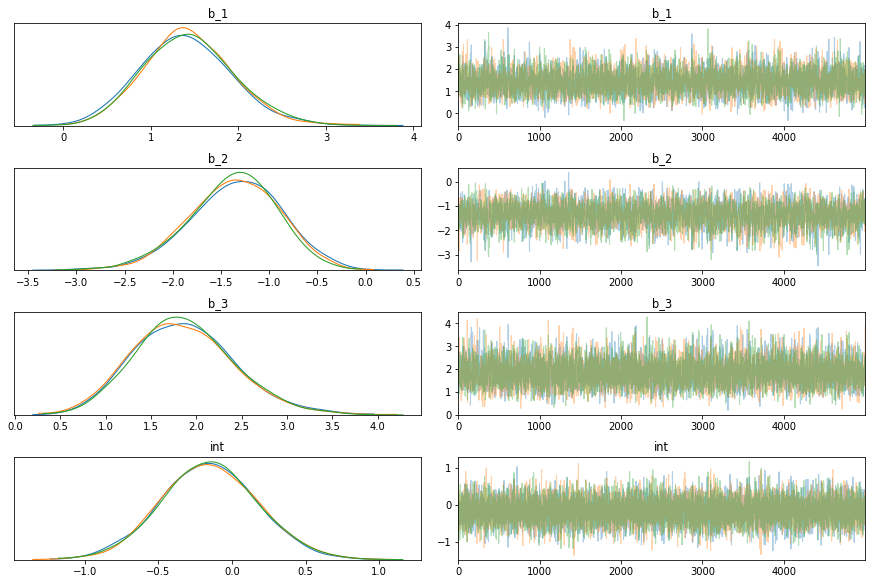

In [30]:
az.plot_trace(idata_jags_model_2);

# Plot Posterior

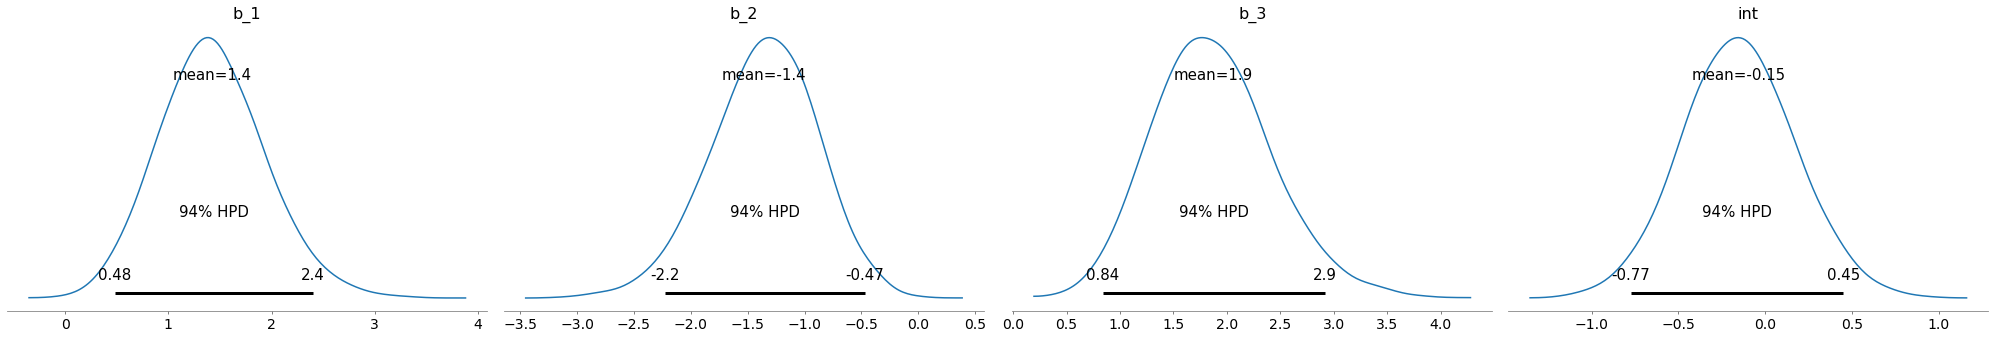

In [66]:
az.plot_posterior(idata_jags_model_2);

# Compare Both Models via the Deviance Information Criterion (DIC)

In [31]:
dic_2 - dic_1

Difference: 1.2063818967049305
Sample standard error: 3.4264200840985906